In [1]:
from bs4 import BeautifulSoup
import sqlite3
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

In [2]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [3]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [4]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [212]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [213]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [214]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [215]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [231]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [5]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [2]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')# if all the values are None remove this row
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df
    

In [3]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)

Cleaning and converting to Numeric

In [4]:
def cleaning_to_numeric(df):
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'].str.replace('GB','').str.replace('1TB','1000').str.strip(),errors='coerce')
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None) 
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh')if x else None)
    df['battery capacity']=pd.to_numeric(df['battery capacity'].str.replace(',','').str.strip(),errors='coerce') 
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
    return df



In [94]:
df_WithNone = Smalldf.copy()
for col in df_WithNone:
    df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
    #|(df_WithNone[col] == 'לא רלוונטי') 
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
df_WithNone["Smartphone"] = np.where( df_WithNone['Smartphone']== "סמארטפון", 1, 0)
df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']!= 'None', 1, 0)
df_WithNone["device structure"] = np.where( df_WithNone['device structure']== "פאבלט", 1, 0)
df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
df_WithNone["Bluetooth"] =  np.where(df_WithNone['Bluetooth']  != 'None' , 1 , 0)
for i in df_WithNone.index:
    try:
        df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
    except:
        df_WithNone['number of cores'][i]=None
for i in df_WithNone.index:
    try:
        df_WithNone['Camera'][i]=eval(df_WithNone['Camera'][i])
    except:
        df_WithNone['Camera'][i]=None
for i in df_WithNone.index:
        try:
            df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
        except: 
            if df_WithNone['resolution'][i]!= None:
                a = df_WithNone['resolution'][i].split('x')
                b = a[1].split('\u200f')
                df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))


    

C:\Users\david\AppData\Local\Temp\ipykernel_4284\3795202336.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
C:\Users\david\AppData\Local\Temp\ipykernel_4284\3795202336.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=None
C:\Users\david\AppData\Local\Temp\ipykernel_4284\3795202336.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [98]:
df_WithNone = df_WithNone.replace({np.nan:None})
df_WithNone=df_WithNone.replace('None', None)

In [97]:
def to_numeric_second_time(df,cols):
    for col in cols:
        df[col]=pd.to_numeric(df[col])

    # df['width']=pd.to_numeric(df['width'])
    # df['wheight']=pd.to_numeric(df['wheight'])
    # df['height']=pd.to_numeric(df['height'])
    # df['Declaration year']=pd.to_numeric(df['Declaration year'])
    # df['radiation level']=pd.to_numeric(df['radiation level'])
    # df['thickness']=pd.to_numeric(df['thickness'])
    # df['battery capacity']=pd.to_numeric(df['battery capacity'])
    # df['RAM memory']=pd.to_numeric(df['RAM memory'])
    # df['CPU speed']=pd.to_numeric(df['CPU speed'])
    # df['number of cores']=pd.to_numeric(df['number of cores'])
    # df['screen size']=pd.to_numeric(df['screen size'])
    # df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'])
    # df['resolution']=pd.to_numeric(df['resolution'])
    # df['Pixel density']=pd.to_numeric(df['Pixel density'])
    # df['refresh rate']=pd.to_numeric(df['refresh rate'])
    # df['Network kind']=pd.to_numeric(df['Network kind'])
    # df['Generation']=pd.to_numeric(df['Generation'])
    # df['Camera']=pd.to_numeric(df['Camera'])
    # df['front camera']=pd.to_numeric(df['front camera'])

    return df

In [99]:
list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
listNotInDescribe
listThatShouldBe=["radiation level","Declaration year","height","wheight","width","thickness","battery capacity",
'screen size','number of cores','CPU speed','RAM memory','refresh rate','Pixel density','resolution','Internal storage volume',
'front camera','Camera','Generation','Network kind']
df_WithNone=to_numeric_second_time(df_WithNone,listThatShouldBe)

list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
listNotInDescribe

['Brand',
 'Operating System',
 'series',
 'Phone for adults',
 'chipset',
 'Processor',
 'Graphics accelerator',
 'Water resistance',
 'screen type',
 'SIM',
 'operator',
 'Flash',
 'Aperture key',
 'video']

its look that we cant become to numeric some columns that are not so importent so we decide to move them from our data to get a more accurate forecast   

In [ ]:
# df_WithNone=df_WithNone.drop(['operator','Flash','Phone for adults'])

We decided to combain the MinPrice and MaxPrice into an avarage price.

In [103]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
df_WithNone.columns

Index(['Minprice', 'Maxprice', 'Brand', 'Operating System', 'Declaration year',
       'device structure', 'series', 'Smartphone', 'radiation level',
       'operating interfaceo', 'kosher phone', 'colors', 'Phone for adults',
       'Internal storage volume', 'chipset', 'Processor', 'number of cores',
       'CPU speed', 'Graphics accelerator', 'RAM memory', 'Memory Card',
       'Water resistance', 'Fingerprint reader', 'screen size', 'screen type',
       'resolution', 'Pixel density', 'refresh rate', 'SIM', 'Network kind',
       'Generation', 'operator', 'WiFi', 'Bluetooth', 'IR', 'GPS', 'NFC',
       'Camera', 'Flash', 'Autofocus', 'Aperture key', 'video', 'front camera',
       'connection 3.5', 'External speaker', 'FM radio', 'height', 'width',
       'thickness', 'wheight', 'battery capacity', 'Removable battery',
       'wireless charging', 'Dual-SIM'],
      dtype='object')

4.0
512.0


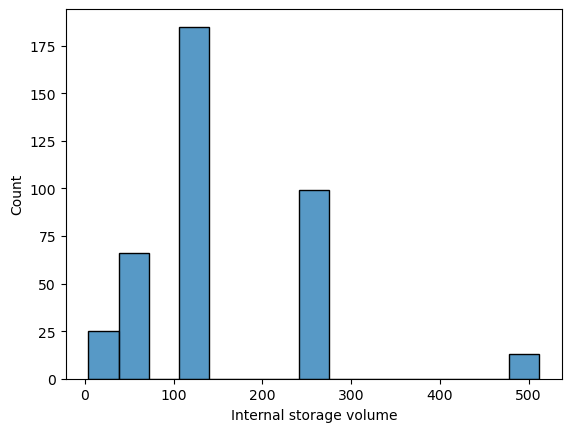

In [38]:
print(df_WithNone['Internal storage volume'].min())
print(df_WithNone['Internal storage volume'].max())

sns.histplot(df_WithNone['Internal storage volume'])
plt.show()

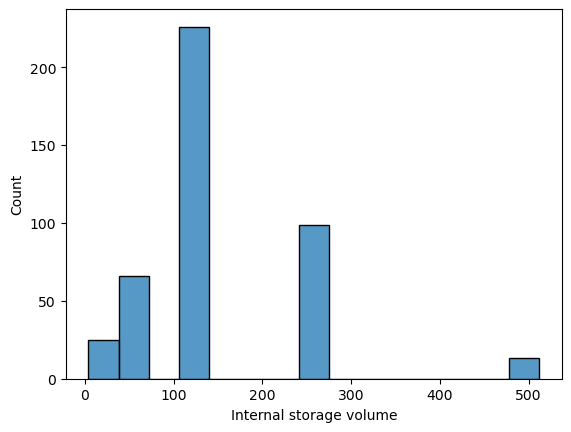

In [42]:
avgsotrage=df_WithNone['Internal storage volume'].mode()[0]
df_WithNone['Internal storage volume']= df_WithNone['Internal storage volume'].fillna(avgsotrage)
sns.histplot(df_WithNone['Internal storage volume'])
plt.show()

In [60]:

# dfnot=dfnot.dropna(thresh=40)   drop the row if i havent more then 40 vals


<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 0 to 883
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Minprice                 319 non-null    int64  
 1   Maxprice                 319 non-null    int64  
 2   Brand                    318 non-null    object 
 3   Operating System         316 non-null    object 
 4   Declaration year         280 non-null    float64
 5   device structure         319 non-null    int32  
 6   series                   248 non-null    object 
 7   Smartphone               319 non-null    int32  
 8   radiation level          110 non-null    float64
 9   operating interfaceo     319 non-null    int32  
 10  kosher phone             319 non-null    int32  
 11  colors                   319 non-null    int32  
 12  Internal storage volume  316 non-null    float64
 13  chipset                  285 non-null    object 
 14  Processor                2

In [36]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,Declaration year,device structure,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Internal storage volume,number of cores,CPU speed,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
count,310.000000,429.000000,429.000000,127.000000,429.000000,429.000000,429.000000,388.000000,298.000000,273.000000,...,429.000000,378.000000,392.000000,398.000000,398.000000,347.000000,429.000000,429.000000,429.000000,429.000000
mean,2019.561290,0.811189,0.890443,0.698228,0.962704,0.020979,0.114219,156.144330,7.604027,2186.560806,...,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914,1894.544289
std,2.187294,0.391815,0.312702,0.376060,0.189707,0.143481,0.318449,98.542032,1.109001,477.522536,...,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821,1399.096567
min,2007.000000,0.000000,0.000000,0.220000,0.000000,0.000000,0.000000,4.000000,2.000000,1.100000,...,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000,108.000000
25%,2019.000000,1.000000,1.000000,0.360000,1.000000,0.000000,0.000000,128.000000,8.000000,1800.000000,...,0.000000,151.700000,71.725000,7.800000,174.250000,3700.000000,0.000000,0.000000,1.000000,849.500000
50%,2020.000000,1.000000,1.000000,0.590000,1.000000,0.000000,0.000000,128.000000,8.000000,2000.000000,...,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000,1494.000000
75%,2021.000000,1.000000,1.000000,0.990000,1.000000,0.000000,0.000000,256.000000,8.000000,2700.000000,...,1.000000,163.700000,76.100000,8.800000,199.000000,5000.000000,0.000000,1.000000,1.000000,2563.000000
max,2022.000000,1.000000,1.000000,1.630000,1.000000,1.000000,1.000000,512.000000,10.000000,3090.000000,...,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000,7850.000000
